# Task
Analyze the provided dataset, build and train multiple regression models to predict the 'Selling_Price', and compare their performance to identify the best model.

# **0. Install required packages**

In [ ]:
!pip install -q shap xgboost lightgbm plotly



# **1. Setup & Imports**


In [ ]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import shap
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# For reproducibility
RSEED = 42
np.random.seed(RSEED)


# **2. Load dataset**

In [ ]:
df = pd.read_csv("/content/car_data.csv")

In [ ]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [ ]:
df.shape

(301, 9)

In [ ]:
df.columns

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Driven_kms',
       'Fuel_Type', 'Selling_type', 'Transmission', 'Owner'],
      dtype='object')

In [ ]:
df.info()
df.describe().style.format(precision=2).background_gradient(cmap='RdBu')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


,Year,Selling_Price,Present_Price,Driven_kms,Owner
count,301.00,301.00,301.00,301.00,301.00
mean,2013.63,4.66,7.63,36947.21,0.04
std,2.89,5.08,8.64,38886.88,0.25
min,2003.00,0.10,0.32,500.00,0.00
25%,2012.00,0.90,1.20,15000.00,0.00
50%,2014.00,3.60,6.40,32000.00,0.00
75%,2016.00,6.00,9.90,48767.00,0.00
max,2018.00,35.00,92.60,500000.00,3.00


# **3. Quick cleaning & checks**

In [ ]:
# 3. Quick cleaning & checks
print("Missing values:\n", df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())

# drop duplicates if any
df = df.drop_duplicates().reset_index(drop=True)
print("After dropping duplicates:", df.shape)


Missing values:
 Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Driven_kms       0
Fuel_Type        0
Selling_type     0
Transmission     0
Owner            0
dtype: int64
Duplicate rows: 2
After dropping duplicates: (299, 9)


# **4. Feature engineering: Brand + Car_Age**

In [ ]:
# Create a mapping for common car names to their brands
brand_mapping = {
    'ritz': 'Maruti', 'sx4': 'Maruti', 'ciaz': 'Maruti', 'wagon r': 'Maruti',
    'swift': 'Maruti', 'vitara brezza': 'Maruti', 'alto k10': 'Maruti',
    'ignis': 'Maruti', 'baleno': 'Maruti', 'dzire': 'Maruti', 'alto 800': 'Maruti',
    'creta': 'Hyundai', 'i20': 'Hyundai', 'grand i10': 'Hyundai', 'eon': 'Hyundai',
    'verna': 'Hyundai', 'xcent': 'Hyundai',
    'city': 'Honda', 'brio': 'Honda', 'amaze': 'Honda', 'jazz': 'Honda',
    'fortuner': 'Toyota', 'innova': 'Toyota', 'corolla altis': 'Toyota', 'etios cross': 'Toyota',
    'etios g': 'Toyota', 'etios gd': 'Toyota', 'etios liva': 'Toyota',
    'camry': 'Toyota',
    'Royal Enfield': 'Royal Enfield', 'Bullet 350': 'Royal Enfield', 'Classic 350': 'Royal Enfield',
    'Electra 350': 'Royal Enfield', 'Continental GT 250': 'Royal Enfield',
    'Bajaj Pulsar 150': 'Bajaj', 'Bajaj Discover 100': 'Bajaj', 'Bajaj Discover 125': 'Bajaj',
    'Bajaj Pulsar 220 dtsi': 'Bajaj', 'Bajaj Pulsar NS 200': 'Bajaj',
    'Honda Activa 4G': 'Honda', 'CB Hornet 160R': 'Honda', 'Activa 3g': 'Honda',
    'Activa 5g': 'Honda', 'Honda CB Shine SP': 'Honda', 'CB Trigger': 'Honda',
    'Honda Unicorn': 'Honda', 'Honda CBR 150': 'Honda', 'Honda CB twister': 'Honda',
    'CB Shine': 'Honda', 'cg 125 executive': 'Honda', 'jawa': 'Jawa',
    'Yamaha FZ S V 2.0': 'Yamaha', 'Yamaha FZ 16': 'Yamaha', 'Yamaha FZ S': 'Yamaha',
    'Fascino': 'Yamaha', 'FX': 'Yamaha', 'MT 150': 'Yamaha', 'R15 V3': 'Yamaha',
    'R15': 'Yamaha',
    'TVS Jupiter 125': 'TVS', 'TVS XL 100': 'TVS', 'TVS Apache RTR 160': 'TVS',
    'TVS Apache RTR 180': 'TVS', 'TVS Wego': 'TVS', 'TVS Apache RR 310': 'TVS',
    'TVS Jupiter': 'TVS',
    'Hero Splendor Plus': 'Hero', 'Glamour 125': 'Hero', 'Super Splendor': 'Hero',
    'Passion Pro': 'Hero', 'Ignitor Disc': 'Hero', 'Extreme 150': 'Hero',
    'Hero Hunk': 'Hero', 'Hero Passion Pro': 'Hero', 'cbz extreme': 'Hero',
    'Hero Extreme': 'Hero', 'Hero Glamour': 'Hero', 'Hero Hunk CBZ Xtreme': 'Hero',
    'KTM RC200': 'KTM', 'KTM Duke 200': 'KTM', 'KTM Duke 390': 'KTM',
    'KTM RC390': 'KTM',
    'UM Renegade Mojave': 'UM', 'UM Renegade Commando': 'UM',
    'Mahindra Mojo XT300': 'Mahindra',
    'Hyosung GT250R': 'Hyosung',
    'Suzuki Access 125': 'Suzuki', 'Suzuki Burgman Street': 'Suzuki',
    'land cruiser': 'Toyota' # Assuming Land Cruiser is Toyota
}

# Apply the mapping, use the first word as a fallback for unseen names
df['Brand'] = df['Car_Name'].apply(lambda x: brand_mapping.get(x, x.split()[0]))

# Group rare brands into 'Other' (brands with freq < 5)
brand_counts = df['Brand'].value_counts()
rare = brand_counts[brand_counts < 5].index
df['Brand'] = df['Brand'].replace(rare, 'Other')

# Car age feature (use 2025 as reference year)
df['Car_Age'] = 2025 - df['Year']

# Drop original Car_Name and Year
df.drop(columns=['Car_Name','Year'], inplace=True)

df.head(6)

,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,Brand,Car_Age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,Maruti,11
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,Maruti,12
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,Maruti,8
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,Maruti,14
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,Maruti,11
5,9.25,9.83,2071,Diesel,Dealer,Manual,0,Maruti,7


# **5. Quick EDA (interpretable & interactive)**

## **5.1 Distribution of Selling Price (static)**

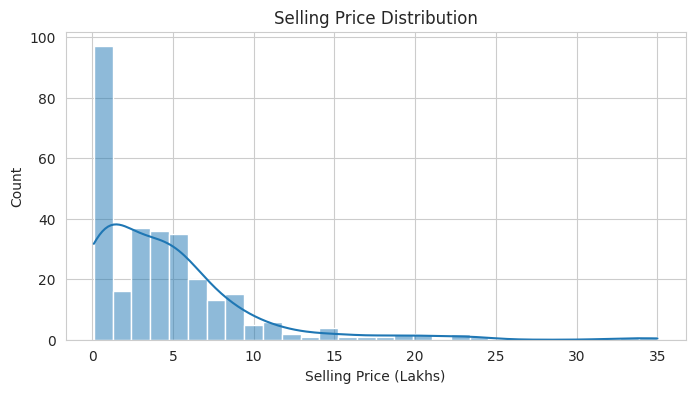

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df['Selling_Price'], bins=30, kde=True)
plt.title("Selling Price Distribution")
plt.xlabel("Selling Price (Lakhs)")
plt.show()

## **5.2 Interactive: Present_Price vs Selling_Price colored by Brand**

In [ ]:
fig = px.scatter(df, x='Present_Price', y='Selling_Price', color='Brand',
                 hover_data=['Car_Age','Driven_kms','Fuel_Type'],
                 title='Present Price vs Selling Price (interactive)')
fig.update_layout(height=500)
fig.show()


## **5.3 Box: Fuel Type vs Selling Price (static)**

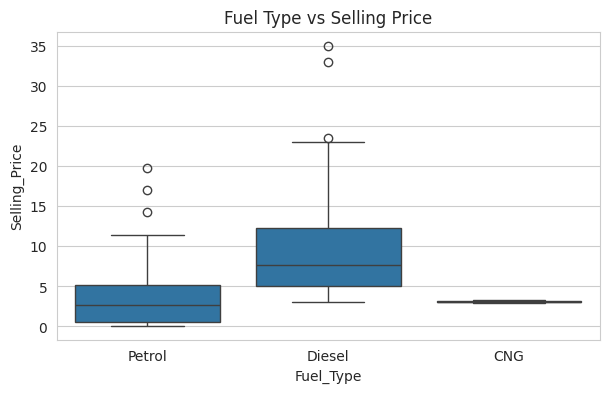

In [ ]:
plt.figure(figsize=(7,4))
sns.boxplot(x='Fuel_Type', y='Selling_Price', data=df)
plt.title("Fuel Type vs Selling Price")
plt.show()

## **5.4 Brand counts (interactive)**

In [ ]:
fig = px.bar(df['Brand'].value_counts().reset_index().rename(columns={'index':'Brand'}),
             x='Brand', y='count', title='Brand frequencies (Top brands + Other)')
fig.update_layout(xaxis={'categoryorder':'total descending'}, height=400)
fig.show()

In [ ]:
print(df['Brand'].unique())

['Maruti' 'Other' 'ertiga' 'Toyota' 'Royal' 'Bajaj' 'Honda' 'Yamaha' 'TVS'
 'Hero' 'Hyundai' 'i10']


# **6. Prepare data for modeling**

In [ ]:
# target and features
target = 'Selling_Price'
X = df.drop(columns=[target])
y = df[target]

# Identify categorical and numeric features
# We'll treat: Brand, Fuel_Type, Selling_type, Transmission as categorical
cat_features = ['Brand','Fuel_Type','Selling_type','Transmission']
num_features = [c for c in X.columns if c not in cat_features]

print("Numeric features:", num_features)
print("Categorical features:", cat_features)


Numeric features: ['Present_Price', 'Driven_kms', 'Owner', 'Car_Age']
Categorical features: ['Brand', 'Fuel_Type', 'Selling_type', 'Transmission']


# **7. Preprocessing pipeline**

In [ ]:
# - OneHotEncode categorical (drop='first')
# - (Optional) scale numerical features (trees don't need scaling but linear models benefit)
num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
], remainder='drop')

# Create a helper to get feature names after preprocessing
def get_feature_names(preprocessor):
    num_cols = num_features
    ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
    cat_cols = ohe.get_feature_names_out(cat_features).tolist()
    return num_cols + cat_cols

df.head()

,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,Brand,Car_Age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,Maruti,11
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,Maruti,12
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,Maruti,8
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,Maruti,14
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,Maruti,11


# **8. Train-test split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=RSEED)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (254, 8) Test shape: (45, 8)


# **9. Baseline models (quick) — using pipeline for each**

In [ ]:
# 9. Baseline models (quick) — using pipeline for each
models = {
    'Linear Regression': Pipeline([('preproc', preprocessor), ('model', LinearRegression())]),
    'Lasso': Pipeline([('preproc', preprocessor), ('model', Lasso(alpha=0.001))]),
    'RandomForest': Pipeline([('preproc', preprocessor), ('model', RandomForestRegressor(n_estimators=200, random_state=RSEED, n_jobs=-1))]),
    'XGBoost': Pipeline([('preproc', preprocessor), ('model', XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=RSEED, n_jobs=-1))]),
    'LightGBM': Pipeline([('preproc', preprocessor), ('model', LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=RSEED, n_jobs=-1))])
}

def evaluate_pipe(pipe, X_test, y_test):
    preds = pipe.predict(X_test)
    return {
        'R2': r2_score(y_test, preds),
        'MAE': mean_absolute_error(y_test, preds),
        'RMSE': np.sqrt(mean_squared_error(y_test, preds))
    }

# Fit and evaluate
baseline_results = {}
for name, pipe in models.items():
    print(f"Training {name} ...")
    pipe.fit(X_train, y_train)
    baseline_results[name] = evaluate_pipe(pipe, X_test, y_test)

pd.DataFrame(baseline_results).T.sort_values('R2', ascending=False)


Training Linear Regression ...
Training Lasso ...
Training RandomForest ...
Training XGBoost ...
Training LightGBM ...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 164
[LightGBM] [Info] Number of data points in the train set: 254, number of used features: 11
[LightGBM] [Info] Start training from score 4.606772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

,R2,MAE,RMSE
XGBoost,0.885701,0.743649,1.812989
RandomForest,0.817249,0.990586,2.292472
Lasso,0.773638,1.406206,2.551387
Linear Regression,0.773635,1.403533,2.551404
LightGBM,0.766590,1.226546,2.590800


# **10. Visual comparison of baseline models**

In [ ]:
# 10. Visual comparison of baseline models
res_df = pd.DataFrame(baseline_results).T.reset_index().rename(columns={'index':'Model'})
fig = px.bar(res_df, x='Model', y='R2', title='Baseline Models R2 Comparison')
fig.show()

# Show MAE table
res_df[['Model','MAE','RMSE']].sort_values('RMSE')


,Model,MAE,RMSE
3,XGBoost,0.743649,1.812989
2,RandomForest,0.990586,2.292472
1,Lasso,1.406206,2.551387
0,Linear Regression,1.403533,2.551404
4,LightGBM,1.226546,2.590800


# **11. Hyperparameter tuning (RandomizedSearchCV) for RandomForest and XGBoost**

In [ ]:
# 11. Hyperparameter tuning (RandomizedSearchCV) for RandomForest and XGBoost
# -> first for RandomForest
rf_pipe = Pipeline([('preproc', preprocessor), ('model', RandomForestRegressor(random_state=RSEED, n_jobs=-1))])

rf_param_dist = {
    'model__n_estimators': [100,200,400],
    'model__max_depth': [None, 6, 10, 15],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

rf_search = RandomizedSearchCV(rf_pipe, rf_param_dist, n_iter=10, cv=4, scoring='r2', n_jobs=-1, random_state=RSEED, verbose=1)
rf_search.fit(X_train, y_train)
print("RF best params:", rf_search.best_params_)
print("RF best CV R2:", rf_search.best_score_)
best_rf = rf_search.best_estimator_


Fitting 4 folds for each of 10 candidates, totalling 40 fits
RF best params: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_depth': 10}
RF best CV R2: 0.8176607497045933


# **-> XGBoost tuning**

In [ ]:
# -> XGBoost tuning
xgb_pipe = Pipeline([('preproc', preprocessor), ('model', XGBRegressor(random_state=RSEED, n_jobs=-1, verbosity=0))])

xgb_param_dist = {
    'model__n_estimators': [100,200,300],
    'model__max_depth': [3,5,6],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(xgb_pipe, xgb_param_dist, n_iter=12, cv=4, scoring='r2', n_jobs=-1, random_state=RSEED, verbose=1)
xgb_search.fit(X_train, y_train)
print("XGB best params:", xgb_search.best_params_)
print("XGB best CV R2:", xgb_search.best_score_)
best_xgb = xgb_search.best_estimator_


Fitting 4 folds for each of 12 candidates, totalling 48 fits
XGB best params: {'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}
XGB best CV R2: 0.8561581929015498


# **12. Evaluate tuned models on test set**

In [ ]:
# 12. Evaluate tuned models on test set
tuned_results = {}
for name, pipe in [('RandomForest_Tuned', best_rf), ('XGBoost_Tuned', best_xgb)]:
    tuned_results[name] = evaluate_pipe(pipe, X_test, y_test)

# Add previous best baseline (LightGBM) if desired
tuned_results_df = pd.DataFrame(tuned_results).T
tuned_results_df


,R2,MAE,RMSE
RandomForest_Tuned,0.854634,0.893032,2.04459
XGBoost_Tuned,0.903617,0.702791,1.66485


# **13. Compare all top models (baseline + tuned)**

In [ ]:
all_results = pd.concat([
    pd.DataFrame(baseline_results).T.assign(model_type='baseline'),
    pd.DataFrame(tuned_results).T.assign(model_type='tuned')
], axis=0)
all_results


,R2,MAE,RMSE,model_type
Linear Regression,0.773635,1.403533,2.551404,baseline
Lasso,0.773638,1.406206,2.551387,baseline
RandomForest,0.817249,0.990586,2.292472,baseline
XGBoost,0.885701,0.743649,1.812989,baseline
LightGBM,0.766590,1.226546,2.590800,baseline
RandomForest_Tuned,0.854634,0.893032,2.044590,tuned
XGBoost_Tuned,0.903617,0.702791,1.664850,tuned


# **14. Choose best model (by R2)**

In [ ]:
# We'll pick the best among tuned models (compare R2)
best_name = all_results['R2'].idxmax()
print("Best model (by R2):", best_name)

# Map name to object
model_map = {
    'RandomForest_Tuned': best_rf,
    'XGBoost_Tuned': best_xgb
}
best_pipeline = model_map.get(best_name, best_rf)  # fallback


Best model (by R2): XGBoost_Tuned


# **15. Get feature names after preprocessing**

In [ ]:
# Step 15: Extract fitted preprocessor + feature names
preproc_fitted = best_pipeline.named_steps['preproc']

def get_feature_names(preprocessor):
    num_features = preprocessor.transformers_[0][2]
    cat_features = preprocessor.transformers_[1][2]
    ohe = preprocessor.transformers_[1][1]
    cat_ohe_features = list(ohe.get_feature_names_out(cat_features))
    return list(num_features) + cat_ohe_features

feature_names = get_feature_names(preproc_fitted)

print("Number of features after preprocessing:", len(feature_names))
feature_names[:40]


Number of features after preprocessing: 19


['Present_Price',
 'Driven_kms',
 'Owner',
 'Car_Age',
 'Brand_Hero',
 'Brand_Honda',
 'Brand_Hyundai',
 'Brand_Maruti',
 'Brand_Other',
 'Brand_Royal',
 'Brand_TVS',
 'Brand_Toyota',
 'Brand_Yamaha',
 'Brand_ertiga',
 'Brand_i10',
 'Fuel_Type_Diesel',
 'Fuel_Type_Petrol',
 'Selling_type_Individual',
 'Transmission_Manual']

# **16. Residuals & Predictions plot for best model**

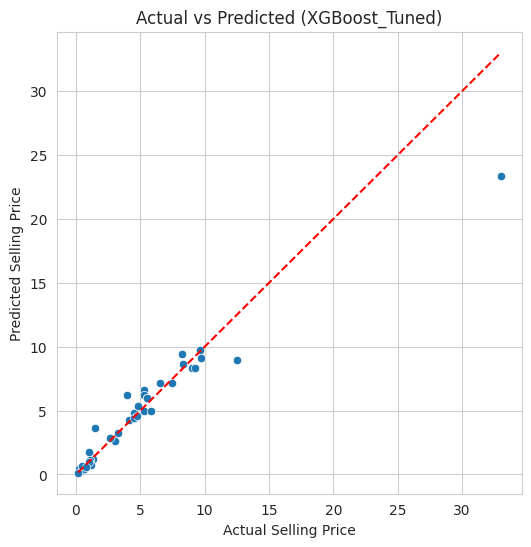

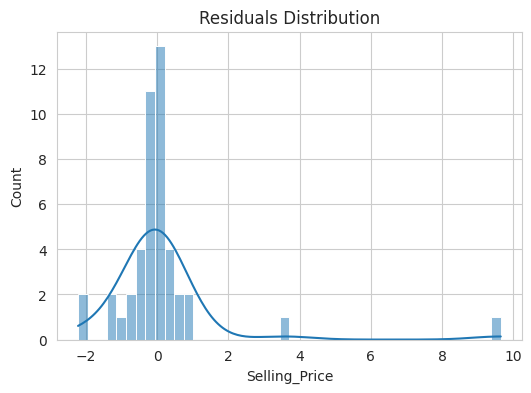

In [ ]:
y_pred_best = best_pipeline.predict(X_test)
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_best)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title(f"Actual vs Predicted ({best_name})")
plt.show()

residuals = y_test - y_pred_best
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

# **17. Final metrics printed clearly**

In [ ]:
print("===== Final Test Metrics for Selected Model =====")
print("Model:", best_name)
print("R2:", round(r2_score(y_test, y_pred_best), 4))
print("MAE:", round(mean_absolute_error(y_test, y_pred_best), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_best)), 4))

===== Final Test Metrics for Selected Model =====
Model: XGBoost_Tuned
R2: 0.9036
MAE: 0.7028
RMSE: 1.6648
